In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm

from quantizer import Quantizer
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

In [2]:
ABX_NB_SAMPLES = 50
QUANTIZER_ABX_DISTANCES = [
    {
        "quantized_latent": {
            "metric": "cosine",
            "weight": 1,
        }
    },
]

In [3]:
quantizers_path = glob("../out/quantizer/*/")
quantizers_path.sort()

In [4]:
quantizers_alias = {}

for quantizer_path in quantizers_path:
    quantizer = Quantizer.reload(quantizer_path, load_nn=False)
    config = quantizer.config
    
    quantizer_i = quantizer_path[-2]
    quantizer_alias = "\n".join((
        f"{','.join(config['dataset']['names'])}",
        f"hidden_layers={len(config['model']['hidden_dims'])}x{config['model']['hidden_dims'][0]}",
        f"{quantizer_i}",
    ))
    
    quantizers_alias[quantizer_alias] = quantizer_path

In [5]:
# quantizers_abx_matrices = utils.pickle_load("../out/quantizer/abx_cache.pickle", {})
quantizers_abx_matrices = {}

for quantizer_alias, quantizer_path in tqdm(quantizers_alias.items()):
    quantizer = Quantizer.reload(quantizer_path)
    
    main_dataset = quantizer.main_dataset
    quantizer_lab = quantizer.get_datasplit_lab(2)
    quantizer_features = quantizer.autoencode_datasplit(2)

    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(quantizer_lab, consonants, vowels)
    
    if quantizer_path not in quantizers_abx_matrices:
        quantizers_abx_matrices[quantizer_path] = {}
    quantizer_abx_matrices = quantizers_abx_matrices[quantizer_path]
    
    for distance in QUANTIZER_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in quantizer_abx_matrices: continue
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, quantizer_features, distance, ABX_NB_SAMPLES)
        
        quantizer_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/quantizer/abx_cache.pickle", quantizers_abx_matrices)

  0%|          | 0/1 [00:00<?, ?it/s]

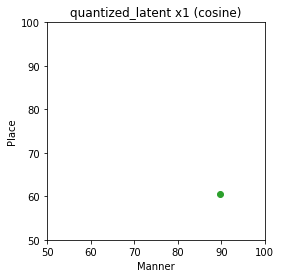

In [6]:
for distance in QUANTIZER_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    
    plt.figure()
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner")
    ax.set_ylabel("Place")
    
    ax.set_title(distance_signature)
    
    for quantizer_alias, quantizer_path in quantizers_alias.items():
        quantizer = Quantizer.reload(quantizer_path, load_nn=False)
        dataset = quantizer.main_dataset
        
        color = "tab:green"

        quantizer_abx_matrix = quantizers_abx_matrices[quantizer_path][distance_signature]
        quantizer_groups_score = abx_utils.get_groups_score(consonants, quantizer_abx_matrix, dataset.phones_infos["consonant_groups"])
        ax.scatter(quantizer_groups_score["manner"], quantizer_groups_score["place"], c=color)
        # raise
    
    plt.show()